In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import itertools
from itertools import chain, combinations
import statsmodels.formula.api as smf
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats
from statsmodels.graphics.regressionplots import *
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import copy
import math
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

/Users/philneff/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load data

In [2]:
path = '../input/'

In [3]:
release_disp = pd.read_csv(f'{path}release_disp_2013-2017.csv')

In [4]:
release_disp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40010 entries, 0 to 40009
Data columns (total 13 columns):
booking_id                  40010 non-null int64
inmate_name                 40010 non-null object
booking_dt                  40010 non-null object
release_dt                  40010 non-null object
booking_charge_desc         40010 non-null object
booking_charge_txt          3022 non-null object
charge_release_dt           40010 non-null object
title_txt                   40010 non-null object
dob                         40010 non-null object
cause_num                   31745 non-null object
jurisdiction_cd             40010 non-null object
release_disposition_desc    40010 non-null object
post_flg                    40010 non-null object
dtypes: int64(1), object(12)
memory usage: 4.0+ MB


In [5]:
bookings_by_date_2016_2017 = pd.read_csv(f'{path}bookings_by_date_2016-2017.csv')
bookings_by_date_2013_2016 = pd.read_csv(f'{path}Bookings_By_Date_2013-2016.csv')

In [137]:
bookings_by_date = pd.concat([bookings_by_date_2016_2017, bookings_by_date_2013_2016])

In [138]:
bookings_by_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71706 entries, 0 to 53846
Data columns (total 14 columns):
booking_id             71706 non-null int64
inmate_name            71706 non-null object
dob                    71706 non-null object
gender_desc            71705 non-null object
height_feet            71706 non-null int64
height_inches          71706 non-null int64
weight                 71706 non-null int64
race_desc              71706 non-null object
booking_charge_desc    71706 non-null int64
jurisdiction_desc      71706 non-null int64
start_dt               71706 non-null object
in_custody_flg         0 non-null float64
view_charges_flg       0 non-null float64
end_dt                 71706 non-null object
dtypes: float64(2), int64(6), object(6)
memory usage: 8.2+ MB


In [139]:
bookings_by_date.drop_duplicates(subset='booking_id', inplace=True)
bookings_by_date.dropna(subset=['gender_desc'], axis=0, inplace=True)

In [140]:
bookings_with_bail = pd.read_csv(f'{path}bookings_with_bail.csv', sep='|')

In [141]:
bookings_with_bail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 19 columns):
booking_id               6175 non-null int64
inmate_name              6175 non-null object
bail_receipt_id          6175 non-null int64
booking_charge_cd        6175 non-null object
bail_receipt_dt          6175 non-null object
booking_charge_desc      6175 non-null object
booking_charge_counts    6175 non-null int64
jurisdiction_cd          6175 non-null object
jurisdiction_desc        6175 non-null object
booking_charge_txt       299 non-null object
bail_fund_type_cd        6175 non-null object
bail_fund_type_desc      6175 non-null object
fine_amt                 6175 non-null float64
start_dt                 6175 non-null object
end_dt                   6175 non-null object
start_receipt_id         6175 non-null int64
end_receipt_id           6175 non-null int64
disbursed_status         6175 non-null object
disbursed_dt             6175 non-null object
dtypes: float64(1), int6

In [142]:
bookings_with_bail.head()

,booking_id,inmate_name,bail_receipt_id,booking_charge_cd,bail_receipt_dt,booking_charge_desc,booking_charge_counts,jurisdiction_cd,jurisdiction_desc,booking_charge_txt,bail_fund_type_cd,bail_fund_type_desc,fine_amt,start_dt,end_dt,start_receipt_id,end_receipt_id,disbursed_status,disbursed_dt
0,2016271070,"AUSTIN, JR, WALTER EUGENE",99231,D600,2016-10-01 00:03:00,D600 - DWI,1,PD1,DISTRICT COURT 1 (TACOMA),NaN,BB,BAIL BOND,6000.0,2016-10-01 00:00:00.0,2017-09-30 23:59:00.0,0,106273,D,2016-10-03 08:44:17.996
1,2016271070,"AUSTIN, JR, WALTER EUGENE",99231,D610,2016-10-01 00:03:00,D610 - DWLS/DWLR,1,PD1,DISTRICT COURT 1 (TACOMA),3RD DEGREE,BB,BAIL BOND,0.0,2016-10-01 00:00:00.0,2017-09-30 23:59:00.0,0,106273,D,2016-10-03 08:44:17.996
2,2016271070,"AUSTIN, JR, WALTER EUGENE",99231,D618,2016-10-01 00:03:00,D618 - OPERATE VEH W/O IGN INTERLOCK DEV,1,PD1,DISTRICT COURT 1 (TACOMA),NaN,BB,BAIL BOND,6000.0,2016-10-01 00:00:00.0,2017-09-30 23:59:00.0,0,106273,D,2016-10-03 08:44:17.996
3,2016274052,"FOURNILLIER, ROGER EARL",99232,D900,2016-10-01 02:19:00,D900 - ASSAULT 4 /DV,1,PD1,DISTRICT COURT 1 (TACOMA),NaN,CASH,CASH,1000.0,2016-10-01 00:00:00.0,2017-09-30 23:59:00.0,0,106273,D,2016-10-03 08:44:06.72
4,2016275014,"GARCIA, RUBEN",99233,T600,2016-10-01 06:19:00,T600 - DWI,1,TACM,TACOMA MUNICIPAL COURT,NaN,BB,BAIL BOND,1000.0,2016-10-01 00:00:00.0,2017-09-30 23:59:00.0,0,106273,D,2016-10-03 08:45:51.526


# Getting booking demographics

Make a separate table with columns unique to `bookings_by_date`, join to `release_disp` using `booking_id` as key. We only get demographics for people booked between `start_dt` and `end_dt`. Records without demographic data are dropped.

In [143]:
gender_race = bookings_by_date[['booking_id', 'gender_desc', 'race_desc']]

In [144]:
df = pd.merge(release_disp, gender_race, on='booking_id', how='left')

In [145]:
predrop_df = df.copy()

In [146]:
predrop_imm_holds = sum(predrop_df['booking_charge_desc'] == 'HOLD IMMIGRAT')
msg = ' booking charges with value \'HOLD IMMIGRAT\' prior to drop.'
print(f'{predrop_imm_holds}{msg}')

115 booking charges with value 'HOLD IMMIGRAT' prior to drop.


In [147]:
null_gender = df[df['gender_desc'].isnull()]['booking_id'].tolist()
null_race = df[df['race_desc'].isnull()]['booking_id'].tolist()

In [148]:
null_gender_ids = set(df[df['booking_id'].isin(null_gender)]['booking_id'])
null_race_ids = set(df[df['booking_id'].isin(null_race)]['booking_id'])

Booking ID records missing gender description are same as records missing race description.

No group of Booking ID records has demographic data for some charges but not others.

In [149]:
assert len(null_gender_ids - null_race_ids) == 0

In [150]:
assert sum(df[df['booking_id'].isin(null_gender_ids)]['gender_desc'].notnull()) == 0

In [151]:
del null_gender, null_race, null_gender_ids, null_race_ids

In [152]:
pre = len(df)
df.dropna(subset=['race_desc', 'gender_desc'], inplace=True)
post = len(df)
print(f"{pre - post} records without demographic data dropped. ")

0 records without demographic data dropped. 


In [153]:
postdrop_imm_holds = sum(df['booking_charge_desc'] == 'HOLD IMMIGRAT')
print(f'{postdrop_imm_holds} booking charges with value \'HOLD IMMIGRAT\' post drop.' )

115 booking charges with value 'HOLD IMMIGRAT' post drop.


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40010 entries, 0 to 40009
Data columns (total 15 columns):
booking_id                  40010 non-null int64
inmate_name                 40010 non-null object
booking_dt                  40010 non-null object
release_dt                  40010 non-null object
booking_charge_desc         40010 non-null object
booking_charge_txt          3022 non-null object
charge_release_dt           40010 non-null object
title_txt                   40010 non-null object
dob                         40010 non-null object
cause_num                   31745 non-null object
jurisdiction_cd             40010 non-null object
release_disposition_desc    40010 non-null object
post_flg                    40010 non-null object
gender_desc                 40010 non-null object
race_desc                   40010 non-null object
dtypes: int64(1), object(14)
memory usage: 4.9+ MB


In [155]:
# Number of booking records for which we both have booking demos and release info
len(set(df['booking_id']))

17715

In [156]:
df.sort_values(by=['booking_id'], inplace=True)

In [157]:
df.head()

,booking_id,inmate_name,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,dob,cause_num,jurisdiction_cd,release_disposition_desc,post_flg,gender_desc,race_desc
32785,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00.0,2017-01-26 08:00:00.0,DEST PROP /DV,NaN,2014-06-15 08:00:00.0,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,D39012,TACM,Time Served,N,MALE,BLACK
36812,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00.0,2017-01-26 08:00:00.0,MURDER 1,NaN,2017-01-26 09:00:00.0,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,13-1-02555-0,SUP,WSI Chain,N,MALE,BLACK
11740,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00.0,2017-01-26 08:00:00.0,ROBBERY 1,ATTEMPTED,2017-01-20 20:00:00.0,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,13-1-02555-0,SUP,Dismissed,N,MALE,BLACK
36813,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00.0,2017-01-26 08:00:00.0,BURGLARY 1,NaN,2017-01-26 09:00:00.0,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,13-1-02555-0,SUP,WSI Chain,N,MALE,BLACK
18749,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00.0,2017-01-26 08:00:00.0,UNL POSS FIREARM 1,NaN,2013-06-24 22:00:00.0,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,NaN,SUP,NCF Final,N,MALE,BLACK


In [158]:
charge_desc_txt = df[['booking_charge_desc', 'booking_charge_txt']].drop_duplicates()
charge_desc_txt.dropna(subset=['booking_charge_txt'], inplace=True)

In [159]:
print(df['charge_release_dt'].min())
print(df['charge_release_dt'].max())

2013-06-24 22:00:00.0
2017-12-05 08:00:00.0


In [160]:
print(df['release_dt'].min())
print(df['release_dt'].max())

2016-10-01 01:00:00.0
2017-09-30 22:10:00.0


In [161]:
print(df['booking_dt'].min())
print(df['booking_dt'].max())

2013-06-21 18:42:00.0
2017-09-30 19:11:00.0


In [162]:
# charge_desc_txt.to_csv('../output/charge_desc_text.csv')

# Calculating time detained

Fields `release_dt` and `booking_dt` are consistent for each `booking_id`; `charge_release_date` varies by charge within `booking_id`.

In [163]:
booking_dates = df.groupby('booking_id')['booking_dt'].nunique()
release_dates = df.groupby('booking_id')['release_dt'].nunique()
assert len(booking_dates) == sum(booking_dates == 1)
assert len(release_dates) == sum(release_dates == 1)
del booking_dates, release_dates

In [164]:
charge_dates = df.groupby('booking_id')['charge_release_dt'].nunique()
assert len(charge_dates) != sum(charge_dates == 1)
del charge_dates

In [165]:
df['release_dt'] = pd.to_datetime(df['release_dt'])
df['booking_dt'] = pd.to_datetime(df['booking_dt'])
df['charge_release_dt'] = pd.to_datetime(df['charge_release_dt'])

In [166]:
df['time_detained'] = df['release_dt'] - df['booking_dt']

In [167]:
# Express as a time delta in days
df['time_detained'] = df['time_detained'] / np.timedelta64(1,'D')

In [168]:
print(df['time_detained'].describe())

count    40010.000000
mean        42.665201
std         87.084736
min          0.004861
25%          1.604167
50%          8.794097
75%         42.140104
max       1314.554167
Name: time_detained, dtype: float64


# Demographic dummy variables

Nice function to create dummy variables for race and gender, which we merge on to table.

In [169]:
race_vars = pd.get_dummies(df['race_desc'])
gender_vars = pd.get_dummies(df['gender_desc'])

In [170]:
race_vars.columns = race_vars.columns.str.replace(' ', '_')
race_vars.columns = race_vars.columns.str.replace('/', '_')
race_vars.columns = race_vars.columns.str.lower()
gender_vars.columns = gender_vars.columns.str.lower()

In [171]:
race_cols = race_vars.columns.tolist()
gender_cols = gender_vars.columns.tolist()

In [172]:
df = pd.concat([df, race_vars], axis=1)
df = pd.concat([df, gender_vars], axis=1)

Race and gender percentages (dropping duplicate booking IDs)

In [173]:
df.drop_duplicates(subset='booking_id')[race_cols].sum()/len(df.drop_duplicates(subset='booking_id'))*100

amer_indian_alaskan      3.036974
asian_pacific_island     5.769122
black                   23.951454
hispanic                 8.399661
unknown                  0.191928
white                   58.650861
dtype: float64

In [174]:
df.drop_duplicates(subset='booking_id')[gender_cols].sum()/len(df.drop_duplicates(subset='booking_id'))*100

female    23.827265
male      76.172735
dtype: float64

In [175]:
# Drop records where race is unknown
predrop = len(df)
df = df[df['unknown'] == 0]
df.drop('unknown', axis=1, inplace=True)
postdrop = len(df)
print(f'Dropped {predrop - postdrop} records with unknown race.')

Dropped 65 records with unknown race.


# Get seriousness

In [176]:
booking_charges = pd.read_csv('../hand/booking_charges.csv')
fugitive_charges = pd.read_csv('../hand/fugitive.csv')

In [177]:
booking_charges = booking_charges[['booking_charge_desc', 'category', 'type']]

In [178]:
seriousness = {'class A felony': 6,
               'class A/B felony': 6,
               'class B felony': 5,
               'class C felony': 4,
               'class c felony': 4,
               'class B/C felony': 5,
               'gross misdemeanor/class B felony': 5,
               'gross misdemeanor/class C felony': 4,
               'gross misdemeanor': 3,                                             
               'gross misdemeanor ': 3,
               'misdemeanor': 2,
               'civil infraction': 1,
               'other': 0
            }

In [179]:
booking_charges['seriousness'] = booking_charges['category'].replace(to_replace=seriousness)
fugitive_charges['seriousness'] = fugitive_charges['category'].replace(to_replace=seriousness)

In [180]:
fugitive_mask = df['booking_charge_desc'] == 'FUGITIVE'

In [181]:
fugitive_df = df[fugitive_mask]
non_fugitive_df = df[~fugitive_mask]

In [182]:
premerge = len(fugitive_df)
fugitive_df = pd.merge(fugitive_df, fugitive_charges, on=['booking_charge_desc', 'booking_charge_txt'], how='left')
postmerge = len(fugitive_df)
assert premerge == postmerge
del premerge, postmerge

premerge = len(non_fugitive_df)
non_fugitive_df = pd.merge(non_fugitive_df, booking_charges, on='booking_charge_desc', how='left')
postmerge = len(non_fugitive_df)
assert premerge == postmerge
del premerge, postmerge

In [183]:
preconcat = len(df)
df = pd.concat([non_fugitive_df, fugitive_df])
postconcat = len(df)
assert preconcat == postconcat
del preconcat, postconcat

df.reset_index(inplace=True, drop=True)
df = df.sort_values(by=['booking_id'])

In [184]:
df['type'] = df['type'].str.strip()
df['type'] = df['type'].str.replace(' ', '_')

In [185]:
predrop = len(df)
predropbookingset = len(set(df['booking_id']))
df = df.dropna(subset=['seriousness'])
postdrop = len(df)
postdropbookingset = len(set(df['booking_id']))
print(f'Dropped {predrop - postdrop} records with null seriousness.')
print(f'Dropped {predropbookingset - postdropbookingset} bookings.')

del predrop, postdrop, predropbookingset, postdropbookingset

Dropped 138 records with null seriousness.
Dropped 29 bookings.


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39807 entries, 0 to 39751
Data columns (total 26 columns):
booking_id                  39807 non-null int64
inmate_name                 39807 non-null object
booking_dt                  39807 non-null datetime64[ns]
release_dt                  39807 non-null datetime64[ns]
booking_charge_desc         39807 non-null object
booking_charge_txt          3004 non-null object
charge_release_dt           39807 non-null datetime64[ns]
title_txt                   39807 non-null object
dob                         39807 non-null object
cause_num                   31584 non-null object
jurisdiction_cd             39807 non-null object
release_disposition_desc    39807 non-null object
post_flg                    39807 non-null object
gender_desc                 39807 non-null object
race_desc                   39807 non-null object
time_detained               39807 non-null float64
amer_indian_alaskan         39807 non-null uint8
asian_pacific_islan

In [187]:
max_seriousness = df.groupby('booking_id')['seriousness'].max()

In [188]:
max_id = df.groupby('booking_id')['seriousness'].idxmax()

In [189]:
df.head()

,booking_id,inmate_name,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,dob,cause_num,...,amer_indian_alaskan,asian_pacific_island,black,hispanic,white,female,male,category,type,seriousness
0,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,DEST PROP /DV,NaN,2014-06-15 08:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,D39012,...,0,0,1,0,0,0,1,gross misdemeanor,public_order,3.0
1,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,MURDER 1,NaN,2017-01-26 09:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,13-1-02555-0,...,0,0,1,0,0,0,1,class A felony,violent,6.0
2,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,ROBBERY 1,ATTEMPTED,2017-01-20 20:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,13-1-02555-0,...,0,0,1,0,0,0,1,class A felony,violent,6.0
3,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,BURGLARY 1,NaN,2017-01-26 09:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,13-1-02555-0,...,0,0,1,0,0,0,1,class A felony,property,6.0
4,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,UNL POSS FIREARM 1,NaN,2013-06-24 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,NaN,...,0,0,1,0,0,0,1,class B felony,public_order,5.0


In [190]:
max_type = []
max_charge_desc = []
for i in max_id:
    charge_type = df.loc[i,:]['type']
    charge_desc = df.loc[i,:]['booking_charge_desc']
    max_type.append(charge_type)
    max_charge_desc.append(charge_desc)

In [191]:
seriousness_type = max_seriousness.to_frame(name='max_seriousness')
seriousness_type['max_charge_type'] = max_type
seriousness_type['max_charge_desc'] = max_charge_desc

In [192]:
seriousness_type.reset_index(inplace=True)

In [193]:
seriousness_type.head()

,booking_id,max_seriousness,max_charge_type,max_charge_desc
0,2013172036,6.0,violent,MURDER 1
1,2013172043,6.0,property,BURGLARY 1
2,2013328017,6.0,violent,CONSP COM MURDER
3,2014308018,6.0,sex,RAPE 2
4,2015015043,0.0,other,HOLD MAT WITNESS


In [194]:
max_type_dummies = pd.get_dummies(seriousness_type['max_charge_type'])

In [195]:
seriousness_type = pd.concat([seriousness_type, max_type_dummies], axis=1)

In [196]:
df = pd.merge(df, seriousness_type, on='booking_id', how='left')

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39807 entries, 0 to 39806
Data columns (total 35 columns):
booking_id                  39807 non-null int64
inmate_name                 39807 non-null object
booking_dt                  39807 non-null datetime64[ns]
release_dt                  39807 non-null datetime64[ns]
booking_charge_desc         39807 non-null object
booking_charge_txt          3004 non-null object
charge_release_dt           39807 non-null datetime64[ns]
title_txt                   39807 non-null object
dob                         39807 non-null object
cause_num                   31584 non-null object
jurisdiction_cd             39807 non-null object
release_disposition_desc    39807 non-null object
post_flg                    39807 non-null object
gender_desc                 39807 non-null object
race_desc                   39807 non-null object
time_detained               39807 non-null float64
amer_indian_alaskan         39807 non-null uint8
asian_pacific_islan

In [198]:
df.reset_index(inplace=True, drop=True)
df = df.sort_values(by=['booking_id'])

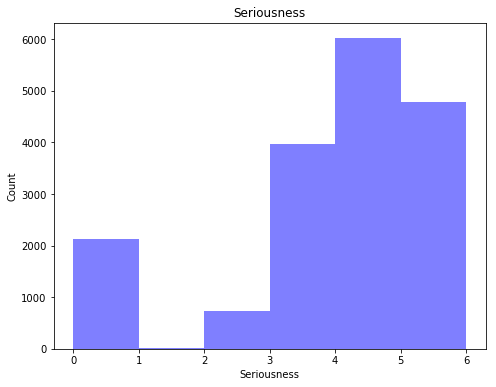

In [199]:
data = df.drop_duplicates(subset='booking_id')['max_seriousness']
num_bins = 6
# the histogram of the data
n, bins, patches = plt.hist(data.dropna(), num_bins, facecolor='blue', alpha=0.5)
 
plt.plot()
plt.xlabel('Seriousness')
plt.xticks(np.arange(0, 7, step=1))
plt.ylabel('Count')
plt.title('Seriousness')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15) 
plt.show()

In [200]:
# data = hold.drop_duplicates(subset='booking_id')['max_seriousness']
# num_bins = 6
# # the histogram of the data
# n, bins, patches = plt.hist(data.dropna(), num_bins, facecolor='blue', alpha=0.5)
 
# plt.plot()
# plt.xlabel('Seriousness')
# plt.xticks(np.arange(0, 7, step=1))
# plt.ylabel('Count')
# plt.title('Seriousness')
 
# # Tweak spacing to prevent clipping of ylabel
# plt.subplots_adjust(left=0.15) 
# plt.show()

In [201]:
felony_mask = df['max_seriousness'] > 3
misdemeanor_mask = (df['max_seriousness'] > 1) & (df['max_seriousness'] <3 )
no_charge_mask = df['max_seriousness'] == 0

In [202]:
df['felony'] = 0
df['felony'][felony_mask] = 1

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [203]:
df['misdemeanor'] = 0
df['misdemeanor'][misdemeanor_mask] = 1

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [204]:
df.drop_duplicates(subset='booking_id')['felony'].value_counts()

1    10806
0     6846
Name: felony, dtype: int64

In [205]:
df.drop_duplicates(subset='booking_id')['misdemeanor'].value_counts()

0    16924
1      728
Name: misdemeanor, dtype: int64

In [206]:
assert sum(df[df['felony'] == 1]['misdemeanor']) == 0
assert sum(df[df['misdemeanor'] == 1]['felony']) == 0

## Count charges

As in Beckett and Evans 2015, we count charges with court cause numbers for each `booking_id`, and then add this to table.

In [207]:
charge_counts = df.groupby('booking_id')['cause_num'].count()

In [208]:
df.set_index('booking_id', inplace=True)

In [209]:
df['charge_count'] = charge_counts

In [210]:
df.reset_index(inplace=True)

In [211]:
df['charge_count'].max()

21

In [212]:
df['charge_topcount'] = df['charge_count'].copy()
mask = df['charge_topcount'] >= 10
df.loc[:, 'charge_topcount'][mask] = 10

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


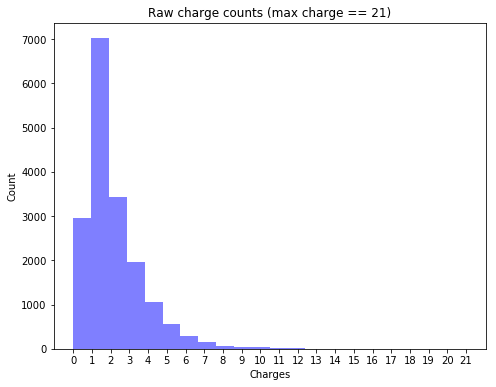

In [213]:
data = df.drop_duplicates(subset='booking_id')['charge_count']
num_bins = 22
# the histogram of the data
n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
 
plt.plot()
plt.xlabel('Charges')
plt.xticks(np.arange(0, 22, step=1))
plt.ylabel('Count')
plt.title('Raw charge counts (max charge == 21)')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15) 
plt.show()

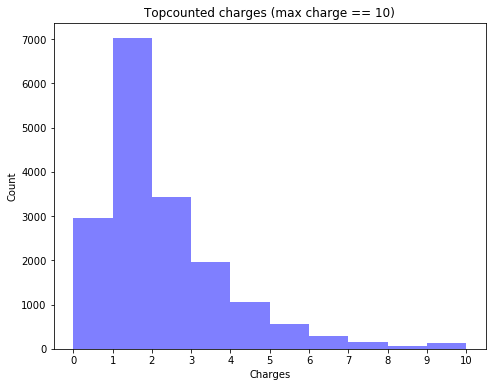

In [214]:
data = df.drop_duplicates(subset='booking_id')['charge_topcount']
num_bins = 10
# the histogram of the data
n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
 
# add a 'best fit' line
plt.plot()
plt.xlabel('Charges')
plt.xticks(np.arange(0, 11, step=1))
plt.ylabel('Count')
plt.title('Topcounted charges (max charge == 10)')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

## Basic masking for immigration holds, release to immigration

Doing some basic masking and birds-eye view calculations of average time detained for different subsets of data:

In [215]:
# Booking IDs of people released to immigration
release_imm_ids = set(df[df['release_disposition_desc'] == "Immigration"]['booking_id'])

In [216]:
# Release jurisdiction == IMM. What does this mean?
juris_imm_ids = set(df[df['jurisdiction_cd'] == "IMM"]['booking_id'])

In [217]:
# Immigration hold IDs
hold_ids = set(df[df['booking_charge_desc'] == 'HOLD IMMIGRAT']['booking_id'])

In [218]:
# Booking IDs of people with canceled detainers
cancel_detainer_ids = set(df[df['release_disposition_desc'] == 'Cancel Detainer']['booking_id'])

In [219]:
hold = df[df['booking_id'].isin(hold_ids)]
no_hold = df[~df['booking_id'].isin(hold_ids)]
release_imm = df[df['booking_id'].isin(release_imm_ids)]
no_release_imm = df[~df['booking_id'].isin(release_imm_ids)]
juris_imm = df[df['booking_id'].isin(juris_imm_ids)]

In [220]:
hold_release_imm = hold[hold['booking_id'].isin(release_imm_ids)]
hold_no_release_imm = hold[~hold['booking_id'].isin(release_imm_ids)]

In [221]:
hold = hold.sort_values(by=['booking_id'])
release_imm = release_imm.sort_values(by=['booking_id'])

In [222]:
#hold.to_csv('subsets/bookings_with_imm_hold.csv', index=False)
#release_imm.to_csv('../output/released_to_imm.csv', index=False)

In [223]:
# Cases with hold with "Cancel Detainer" release disp
len(hold_ids.intersection(cancel_detainer_ids))

5

In [224]:
# Cases with holds released to immigration
len(hold_ids.intersection(release_imm_ids))

76

In [225]:
# Cases with holds release jurisdiction == IMM
len(hold_ids.intersection(juris_imm_ids))

111

In [226]:
# Canceled detainers release jurisdiction == IMM
len(juris_imm_ids.intersection(cancel_detainer_ids))

5

In [227]:
hold['release_disposition_desc'].value_counts() / len(hold) * 100

Immigration               20.365535
WSI Chain                 14.360313
Dismissed                 13.838120
Credit for Time Served     9.399478
Time Served                6.266319
Mini-Chain                 6.005222
Court Order                4.699739
PR                         3.916449
NCF Final                  3.655352
Suspended Sentence         3.394256
NCF, Pending Inv           3.133159
NCF TacM                   1.827676
Police Department          1.305483
No Charges Filed           1.305483
Cancel Detainer            1.305483
NCF Dist                   1.044386
No Prob Cause              0.783290
Not Guilty Verdict         0.783290
US Marshall                0.522193
Bail Bond                  0.522193
FBI                        0.522193
Cash Bail                  0.522193
NCF, LAKEWOOD              0.522193
Name: release_disposition_desc, dtype: float64

In [228]:
no_hold['release_disposition_desc'].value_counts() / len(no_hold) * 100

Bail Bond                         13.375101
PR                                10.952719
Time Served                        9.900061
WSI Chain                          7.926644
Dismissed                          7.893669
Credit for Time Served             6.851157
NCF Final                          5.869521
Court Order                        5.230317
Mini-Chain                         4.116782
Probation/Parole Officer           3.807325
NCF, Pending Inv                   3.193486
PDC                                3.122463
SIP                                2.432528
No Charges Filed                   2.369115
Police Department                  1.585329
Cash Bail                          1.519379
Suspended Sentence                 1.412845
NCF Dist                           1.341822
Drug Court                         1.278409
NCF TacM                           1.128754
Cancel Detainer                    1.078024
Administrative Booking             1.032366
No Prob Cause                   

## Simple masking for immigration holds and release to immigration

In [229]:
hold_mask = df['booking_id'].isin(hold_ids)
release_imm_mask = df['booking_id'].isin(release_imm_ids)
juris_imm_mask = df['booking_id'].isin(juris_imm_ids)

In [230]:
df['imm_hold'] = 0
df.loc[hold_mask, 'imm_hold'] = 1

In [231]:
df['release_to_imm'] = 0
df.loc[release_imm_mask, 'release_to_imm'] = 1

In [232]:
df['juris_imm'] = 0
df.loc[release_imm_mask, 'juris_imm'] = 1

# Bookings held longer on detainer than on other charges

Here we're looking for bookings where the charge release date for immigration hold was greater than release date for other charges. Note that charge release dates may be later than actual release dates. What we're looking for is records where actual release date and hold release date are both later than release dates for other charges. Could consider adding additional logic below to control for this but for now we'll hand check.

In [233]:
df['charge_delta'] = df['charge_release_dt'] - df['booking_dt']
df['charge_delta'] = df['charge_delta'] / np.timedelta64(1,'D') 

In [234]:
held_longer_on_detainer = []
for b_id in hold_ids:
    booking = df[df['booking_id'] == b_id]

    non_hold_charge_deltas = booking[booking['booking_charge_desc'] != 'HOLD IMMIGRAT']['charge_delta']

    hold_charge_delta = float(booking[booking['booking_charge_desc'] == 'HOLD IMMIGRAT']['charge_delta'])
    
    if hold_charge_delta > non_hold_charge_deltas.max():
        
        held_longer_on_detainer.append(b_id)

In [235]:
# df[df['booking_id'].isin(held_longer_on_detainer)].to_csv('../output/held_longer_on_detainer.csv', index=False)

# Bail

In [236]:
bookings_with_bail['booking_charge_cd_desc'] = bookings_with_bail['booking_charge_desc'].copy()

In [237]:
bookings_with_bail['booking_charge_desc'] = bookings_with_bail['booking_charge_cd_desc'].str.split(' - ', 1).str[1]

In [238]:
bailcols = ['booking_id',
            'bail_receipt_id',
            'bail_receipt_dt',
            'booking_charge_desc',
            'bail_fund_type_cd',
            'bail_fund_type_desc',
            'fine_amt',
            'start_receipt_id',
            'end_receipt_id',
            'disbursed_status',
            'disbursed_dt']

This merge duplicates some records with multiple charges with same description.
- Do it after counting charges & other groupby calculations?
- De-duplicate bail payments by dropping duplicate `bail_receipt_id` values when doing calculations?

In [239]:
bail_df = pd.merge(df, bookings_with_bail[bailcols], on=['booking_id', 'booking_charge_desc'], how='left')

In [240]:
bail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40475 entries, 0 to 40474
Data columns (total 52 columns):
booking_id                  40475 non-null int64
inmate_name                 40475 non-null object
booking_dt                  40475 non-null datetime64[ns]
release_dt                  40475 non-null datetime64[ns]
booking_charge_desc         40475 non-null object
booking_charge_txt          3055 non-null object
charge_release_dt           40475 non-null datetime64[ns]
title_txt                   40475 non-null object
dob                         40475 non-null object
cause_num                   32209 non-null object
jurisdiction_cd             40475 non-null object
release_disposition_desc    40475 non-null object
post_flg                    40475 non-null object
gender_desc                 40475 non-null object
race_desc                   40475 non-null object
time_detained               40475 non-null float64
amer_indian_alaskan         40475 non-null uint8
asian_pacific_islan

In [241]:
bail_df.head()

,booking_id,inmate_name,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,dob,cause_num,...,charge_delta,bail_receipt_id,bail_receipt_dt,bail_fund_type_cd,bail_fund_type_desc,fine_amt,start_receipt_id,end_receipt_id,disbursed_status,disbursed_dt
0,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,DEST PROP /DV,NaN,2014-06-15 08:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,D39012,...,358.554167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,MURDER 1,NaN,2017-01-26 09:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,13-1-02555-0,...,1314.595833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,ROBBERY 1,ATTEMPTED,2017-01-20 20:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,13-1-02555-0,...,1309.054167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,BURGLARY 1,NaN,2017-01-26 09:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,13-1-02555-0,...,1314.595833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013172036,"SMITH, JR, ROBERT LEON",2013-06-21 18:42:00,2017-01-26 08:00:00,UNL POSS FIREARM 1,NaN,2013-06-24 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",1980-01-04 00:00:00.0,NaN,...,3.137500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
bail_df.groupby('booking_id')['bail_receipt_id'].nunique().value_counts()

0    14141
1     3175
2      286
3       44
4        4
5        2
Name: bail_receipt_id, dtype: int64

In [243]:
# Is this ever summing duplicated bail amounts?
bail_df.groupby(['booking_id', 'bail_receipt_id'])['fine_amt'].sum()

booking_id  bail_receipt_id
2015260025  99419.0            100000.0
2015289022  99910.0               100.0
2016156033  100580.0            15000.0
2016166054  99373.0             40000.0
2016174004  99541.0             35000.0
            99542.0              1500.0
2016197021  100378.0            25000.0
2016210020  101187.0           100000.0
2016211052  99596.0              3000.0
2016212024  100829.0            15000.0
2016215032  99869.0             10000.0
2016233004  99342.0            200000.0
2016237022  99441.0            100000.0
2016237049  99602.0             20000.0
2016238004  99913.0             20000.0
2016238012  99783.0            100000.0
            99784.0              5000.0
2016239016  99682.0               250.0
2016243045  99296.0             15000.0
2016249029  99686.0             20000.0
2016250022  100125.0            10000.0
            100126.0             1700.0
2016250046  99866.0             20000.0
2016253011  99612.0            100000.0
2016254020  

In [244]:
bail_df.set_index('booking_id').loc[2017272028].T

inmate_name                                              TAULOLO, TAUNUUTASI 
booking_dt                                                2017-09-29 12:41:00
release_dt                                                2017-09-29 14:15:00
booking_charge_desc                                                       DWI
booking_charge_txt                                                        NaN
charge_release_dt                                         2017-09-29 22:00:00
title_txt                   Report Criteria: 10/01/2016 to 09/30/2017, Dis...
dob                                                     1981-11-28 00:00:00.0
cause_num                                                           6YC000659
jurisdiction_cd                                                           PD1
release_disposition_desc                                            Bail Bond
post_flg                                                                    N
gender_desc                                                     

# Drop duplicates

Subsequent cell drops duplicate booking IDs so count = individual bookings, not charges. Mask any variables that we want to analyze further.

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39807 entries, 0 to 39806
Data columns (total 43 columns):
booking_id                  39807 non-null int64
inmate_name                 39807 non-null object
booking_dt                  39807 non-null datetime64[ns]
release_dt                  39807 non-null datetime64[ns]
booking_charge_desc         39807 non-null object
booking_charge_txt          3004 non-null object
charge_release_dt           39807 non-null datetime64[ns]
title_txt                   39807 non-null object
dob                         39807 non-null object
cause_num                   31584 non-null object
jurisdiction_cd             39807 non-null object
release_disposition_desc    39807 non-null object
post_flg                    39807 non-null object
gender_desc                 39807 non-null object
race_desc                   39807 non-null object
time_detained               39807 non-null float64
amer_indian_alaskan         39807 non-null uint8
asian_pacific_islan

In [246]:
df = df.drop_duplicates(subset=['booking_id'])

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17652 entries, 0 to 39806
Data columns (total 43 columns):
booking_id                  17652 non-null int64
inmate_name                 17652 non-null object
booking_dt                  17652 non-null datetime64[ns]
release_dt                  17652 non-null datetime64[ns]
booking_charge_desc         17652 non-null object
booking_charge_txt          1515 non-null object
charge_release_dt           17652 non-null datetime64[ns]
title_txt                   17652 non-null object
dob                         17652 non-null object
cause_num                   13515 non-null object
jurisdiction_cd             17652 non-null object
release_disposition_desc    17652 non-null object
post_flg                    17652 non-null object
gender_desc                 17652 non-null object
race_desc                   17652 non-null object
time_detained               17652 non-null float64
amer_indian_alaskan         17652 non-null uint8
asian_pacific_islan

In [248]:
# Selecting to drop columns not used in regression analysis
booking_cols = ['booking_id',
                'inmate_name',
                'time_detained',
                'race_desc',
                'amer_indian_alaskan',
                'asian_pacific_island',
                'black',
                'hispanic',
                'white',
                'female',
                'male',
                'max_seriousness',
                'max_charge_type',
                'max_charge_desc',
                'felony',
                'misdemeanor',
                'drug',
                'property',
                'public_order',
                'sex',
                'violent',
                'other',
                'charge_count',
                'charge_topcount',
                'imm_hold',
                'release_to_imm'
               ]

In [249]:
df = df[booking_cols]

In [250]:
df.set_index('booking_id',inplace=True)

# More descriptive analysis

In [251]:
# Adding a column for log of time detained
df.loc[:,'log_time_detained'] = np.log(df['time_detained'])

Bookings with immigration holds have longer detention time. Using logged time makes this clearer.

In [252]:
hold_order = ['No hold', 'Hold']

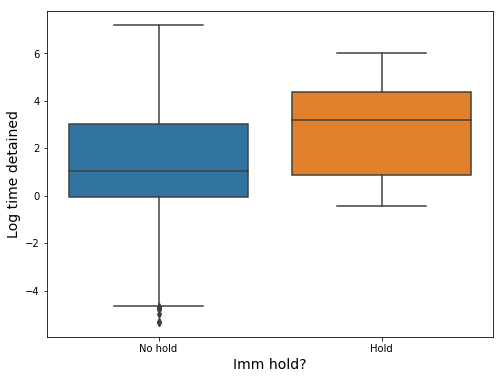

In [253]:
df['imm_hold_text'] = df['imm_hold'].replace({0: 'No hold', 1: 'Hold'})
bplot1 = sns.boxplot(data=df, y='log_time_detained', x='imm_hold_text', order=hold_order)
bplot1.set_xlabel('Imm hold?', fontsize=14)
bplot1.set_ylabel('Log time detained', fontsize=14)

A couple outliers with lots of charges in imm_hold category?

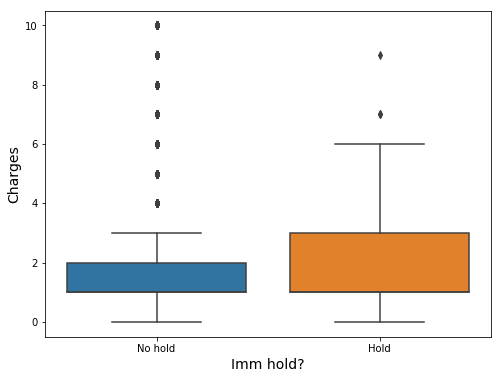

In [254]:
bplot2 = sns.boxplot(data=df, y='charge_topcount', x='imm_hold_text', order=hold_order)
bplot2.set_xlabel('Imm hold?', fontsize=14)
bplot2.set_ylabel('Charges', fontsize=14)

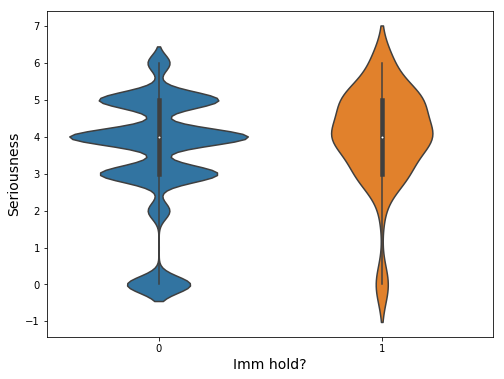

In [255]:
bplot2 = sns.violinplot(data=df, y='max_seriousness', x='imm_hold')
bplot2.set_xlabel('Imm hold?', fontsize=14)
bplot2.set_ylabel('Seriousness', fontsize=14)

Felonies detained longer.

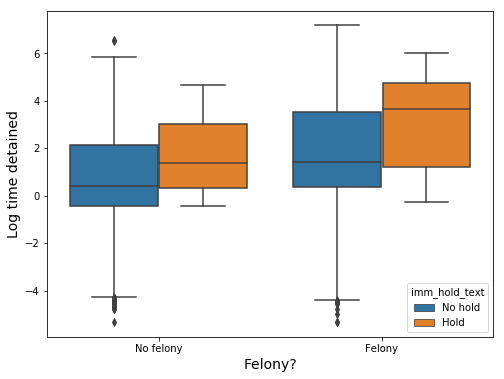

In [256]:
df['felony_text'] = df['felony'].replace({0: 'No felony', 1: 'Felony'})
fel_order = ['No felony', 'Felony']
bplot2 = sns.boxplot(data=df, y='log_time_detained', x='felony_text', hue='imm_hold_text', order=fel_order)
bplot2.set_xlabel('Felony?', fontsize=14)
bplot2.set_ylabel('Log time detained', fontsize=14)

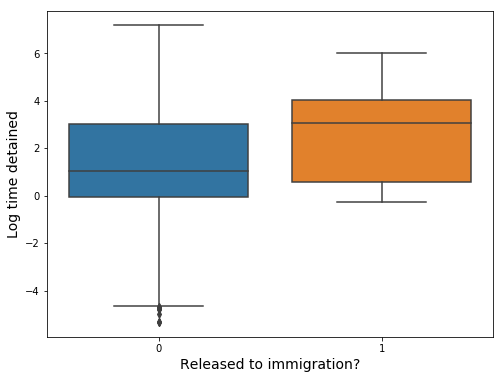

In [257]:
d0 = df[df['release_to_imm'] == 0]['log_time_detained']
d1 = df[df['release_to_imm'] == 1]['log_time_detained']
bplot2 = sns.boxplot(data=[d0, d1])
bplot2.set_xlabel('Released to immigration?', fontsize=14)
bplot2.set_ylabel('Log time detained', fontsize=14)

More serious charges generally detained longer. Lots of outliers for 0 seriousness, probably because it includes holds, community custody, etc.

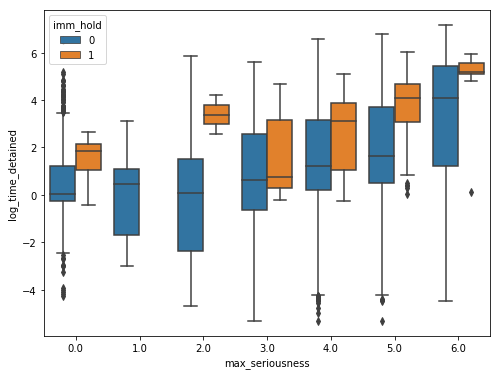

In [258]:
plt = sns.boxplot(data=df, x="max_seriousness", y="log_time_detained", hue='imm_hold')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

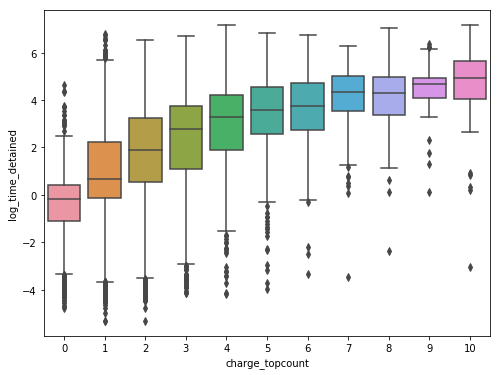

In [259]:
plt = sns.boxplot(data=df, x="charge_topcount", y="log_time_detained")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [260]:
race_order = ['WHITE',
         'BLACK',
         'HISPANIC',
         'ASIAN/PACIFIC ISLAND',
         'AMER INDIAN/ALASKAN']

Heavy `charge_count` bias for `BLACK` and `AMER INDIAN/ALASKAN`, other race categories roughly similar. Using topcounted charges emphasizes this.

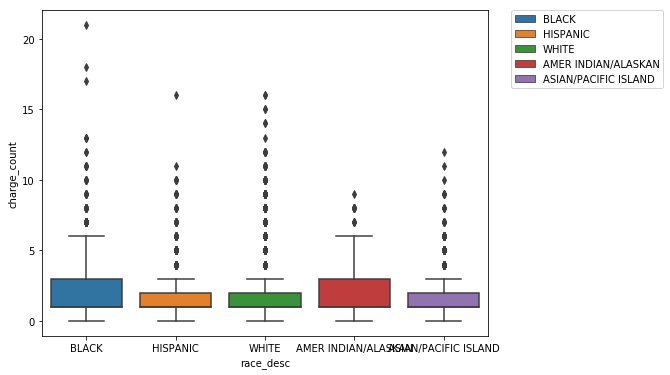

In [261]:
plt = sns.boxplot(data=df, x="race_desc", y="charge_count", hue="race_desc", dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

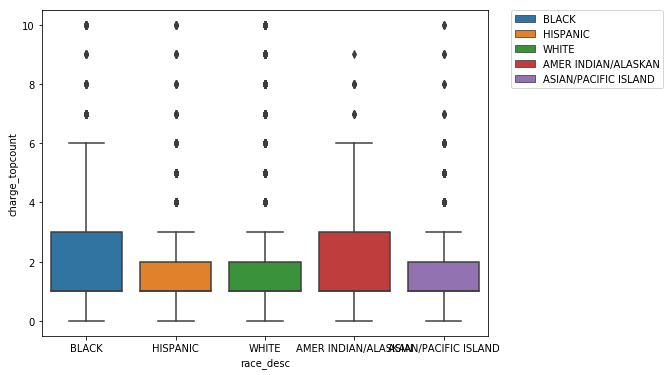

In [262]:
plt = sns.boxplot(data=df, x="race_desc", y="charge_topcount", hue="race_desc", dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Time in detention is roughly similar across race categories.

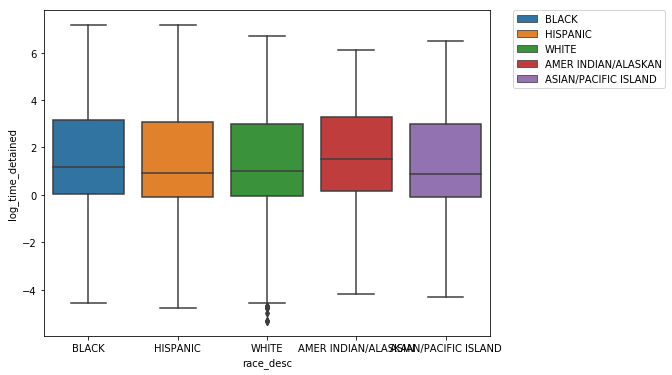

In [263]:
plt = sns.boxplot(data=df, x="race_desc", y="log_time_detained", hue="race_desc", dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

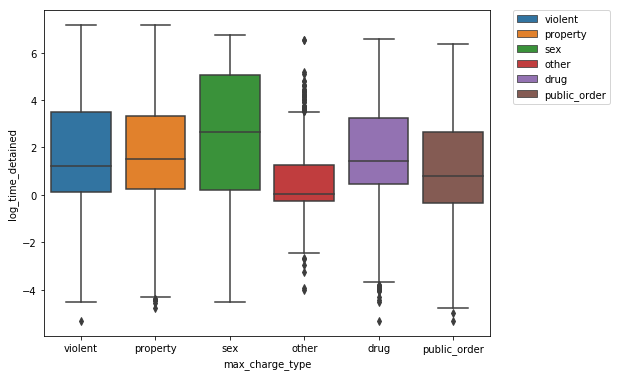

In [264]:
plt = sns.boxplot(data=df, x="max_charge_type", y="log_time_detained", hue="max_charge_type", dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [265]:
race_holds = df.groupby('race_desc')['imm_hold'].sum()

In [266]:
n = df['race_desc'].value_counts()

In [267]:
race_hold_df = pd.DataFrame([n, race_holds]).T

In [268]:
race_hold_df.columns = ['n', 'imm_hold']

In [269]:
race_hold_df['percent'] = race_hold_df['imm_hold']/race_hold_df['n'] *100

In [270]:
race_hold_df

,n,imm_hold,percent
AMER INDIAN/ALASKAN,538,0,0.000000
ASIAN/PACIFIC ISLAND,1021,8,0.783546
BLACK,4236,3,0.070822
HISPANIC,1484,99,6.671159
WHITE,10373,5,0.048202


In [271]:
df.groupby('race_desc')['imm_hold'].value_counts()

race_desc             imm_hold
AMER INDIAN/ALASKAN   0             538
ASIAN/PACIFIC ISLAND  0            1013
                      1               8
BLACK                 0            4233
                      1               3
HISPANIC              0            1385
                      1              99
WHITE                 0           10368
                      1               5
Name: imm_hold, dtype: int64

In [272]:
sns.set(style="whitegrid", color_codes=True)

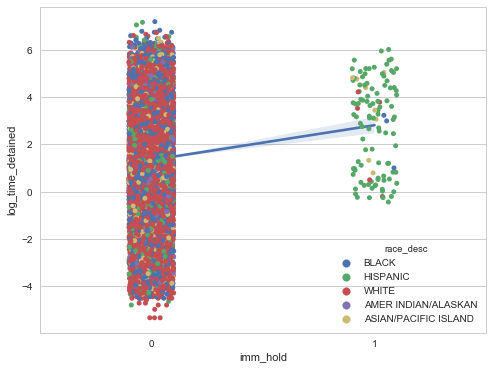

In [273]:
# a4_dims = (11.7, 8.27)
# fig, ax = plt.subplots(figsize=a4_dims)
sns.stripplot(x="imm_hold", y="log_time_detained", hue="race_desc", marker='o', data=df, jitter=True);
sns.regplot(x="imm_hold", y="log_time_detained", truncate=True, marker='', data=df);

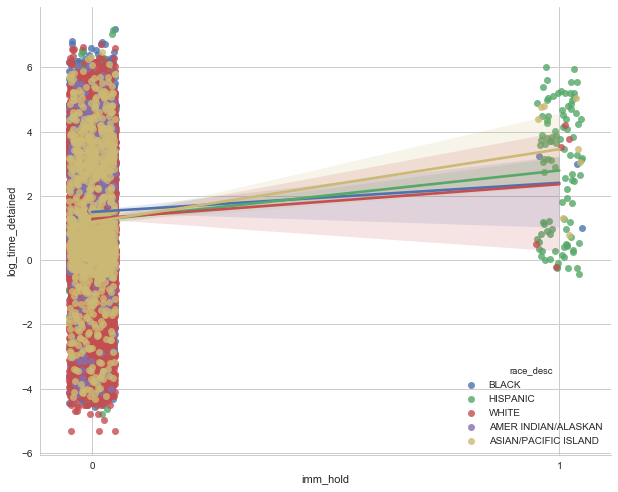

In [274]:
plt = sns.lmplot(x="imm_hold", y="log_time_detained", hue="race_desc", truncate=True, markers='o', legend_out=False, x_jitter=0.05, data=df, size=7, aspect=1.25);
plt.set(xticks=[0, 1])
plt.despine()

In [275]:
hold = df['imm_hold'] == 1
no_hold = df['imm_hold'] == 0
release_to_imm = df['release_to_imm'] == 1
no_release_to_imm = df['release_to_imm'] == 0

In [276]:
df[hold].describe()

,time_detained,amer_indian_alaskan,asian_pacific_island,black,hispanic,white,female,male,max_seriousness,felony,...,property,public_order,sex,violent,other,charge_count,charge_topcount,imm_hold,release_to_imm,log_time_detained
count,115.000000,115.0,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,...,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.0,115.000000,115.000000
mean,57.779825,0.0,0.069565,0.026087,0.860870,0.043478,0.034783,0.965217,4.017391,0.739130,...,0.156522,0.295652,0.069565,0.234783,0.052174,1.965217,1.965217,1.0,0.660870,2.807479
std,78.822765,0.0,0.255526,0.160092,0.347597,0.204824,0.184031,0.184031,1.311104,0.441031,...,0.364939,0.458332,0.255526,0.425718,0.223351,1.695869,1.695869,0.0,0.475486,1.890382
min,0.647222,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,-0.435066
25%,2.377083,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.865001
50%,24.320139,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,1.000000,3.191305
75%,81.071875,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,5.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,3.000000,1.0,1.000000,4.395332
max,405.518056,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,9.000000,1.0,1.000000,6.005165


In [277]:
df.describe()

,time_detained,amer_indian_alaskan,asian_pacific_island,black,hispanic,white,female,male,max_seriousness,felony,...,property,public_order,sex,violent,other,charge_count,charge_topcount,imm_hold,release_to_imm,log_time_detained
count,17652.000000,17652.000000,17652.000000,17652.000000,17652.00000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,...,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000
mean,25.359933,0.030478,0.057840,0.239973,0.08407,0.587639,0.238330,0.761670,3.521187,0.612169,...,0.241672,0.272207,0.015862,0.240539,0.119533,1.789259,1.782801,0.006515,0.004362,1.345339
std,62.996963,0.171904,0.233448,0.427079,0.27750,0.492273,0.426074,0.426074,1.579590,0.487270,...,0.428109,0.445109,0.124946,0.427423,0.324424,1.682895,1.642091,0.080454,0.065904,2.142756
min,0.004861,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.326488
25%,0.965972,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-0.034620
50%,2.836111,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.042434
75%,20.833507,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,5.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,3.036563
max,1314.554167,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,6.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,10.000000,1.000000,1.000000,7.181253


In [278]:
df[hold]['max_charge_type'].value_counts()

public_order    34
violent         27
drug            22
property        18
sex              8
other            6
Name: max_charge_type, dtype: int64

In [279]:
df[hold]['max_charge_desc'].value_counts().head()

DWI                          15
UPCS                         11
UPCS W INTENT                 8
POSSESS STOLEN VEHICLE        6
DUI WITH PRIOR CONVICTION     5
Name: max_charge_desc, dtype: int64

In [280]:
df[hold]['felony'].value_counts() / sum(hold) * 100

1    73.913043
0    26.086957
Name: felony, dtype: float64

In [281]:
df[~hold]['felony'].value_counts()

1    10721
0     6816
Name: felony, dtype: int64

In [282]:
df['felony'].value_counts() / len(df) * 100

1    61.216859
0    38.783141
Name: felony, dtype: float64

In [283]:
pd.crosstab(df.felony, df.imm_hold, margins=True, normalize='columns') * 100

imm_hold,0,1,All
felony,,,
0,38.866397,26.086957,38.783141
1,61.133603,73.913043,61.216859


In [284]:
pd.crosstab(df.felony, df.imm_hold)

imm_hold,0,1
felony,,
0,6816,30
1,10721,85


Significant relationship between felony and presence of immigration hold

In [285]:
scipystats.chi2_contingency(pd.crosstab(df.felony, df.imm_hold))

(7.3299779868669797,
 0.0067813884427315885,
 1,
 array([[  6801.39938817,     44.60061183],
        [ 10735.60061183,     70.39938817]]))

In [286]:
scipystats.chi2_contingency(pd.crosstab(df.max_seriousness, df.imm_hold))

(12.766834322308034,
 0.046891736755448714,
 6,
 array([[  2.11413642e+03,   1.38635849e+01],
        [  1.39087922e+01,   9.12077952e-02],
        [  7.23257195e+02,   4.74280535e+00],
        [  3.95009699e+03,   2.59030138e+01],
        [  5.97879368e+03,   3.92063222e+01],
        [  4.01566701e+03,   2.63329934e+01],
        [  7.41139927e+02,   4.86007251e+00]]))

In [287]:
pd.crosstab(df.race_desc, df.felony, margins=True, normalize='index') * 100

felony,0,1
race_desc,,
AMER INDIAN/ALASKAN,41.635688,58.364312
ASIAN/PACIFIC ISLAND,36.826641,63.173359
BLACK,37.865911,62.134089
HISPANIC,37.398922,62.601078
WHITE,39.400366,60.599634
All,38.783141,61.216859


Insignificant relationship between felony and race

In [288]:
scipystats.chi2_contingency(pd.crosstab(df.race_desc, df.felony))

(7.8532300839048235,
 0.097104953187627005,
 4,
 array([[  208.65329708,   329.34670292],
        [  395.97586676,   625.02413324],
        [ 1642.85384092,  2593.14615908],
        [  575.54180829,   908.45819171],
        [ 4022.97518695,  6350.02481305]]))

In [289]:
df[hold]['max_seriousness'].value_counts()

4.0    42
5.0    34
3.0    22
6.0     9
0.0     6
2.0     2
Name: max_seriousness, dtype: int64

In [290]:
df[hold]['charge_topcount'].describe()

count    115.000000
mean       1.965217
std        1.695869
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        9.000000
Name: charge_topcount, dtype: float64

In [291]:
print(df[hold].groupby('race_desc')['race_desc'].count() / len(df[hold]) * 100)
print('\n')
print(f'n = {len(hold)}')

race_desc
ASIAN/PACIFIC ISLAND     6.956522
BLACK                    2.608696
HISPANIC                86.086957
WHITE                    4.347826
Name: race_desc, dtype: float64


n = 17652


In [292]:
print(df.groupby('race_desc')['race_desc'].count() / len(df) * 100)
print('\n')
print(f'n = {len(df)}')

race_desc
AMER INDIAN/ALASKAN      3.047813
ASIAN/PACIFIC ISLAND     5.784047
BLACK                   23.997281
HISPANIC                 8.406979
WHITE                   58.763879
Name: race_desc, dtype: float64


n = 17652


In [293]:
# Race breakdown of cases released to immigration:
print(df.groupby('race_desc')['release_to_imm'].sum())

race_desc
AMER INDIAN/ALASKAN      0
ASIAN/PACIFIC ISLAND     3
BLACK                    2
HISPANIC                67
WHITE                    5
Name: release_to_imm, dtype: int64


In [294]:
# Percent of bookings with immigration holds released to immigration
print(sum(df[hold]['release_to_imm'] == 1) / len(df[hold]) * 100)
print('\n')
print(f'n = {len(df[hold])}')

66.0869565217


n = 115


In [295]:
hispanic = df[df.hispanic == 1]

In [296]:
hispanic_with_hold = hispanic[hispanic.imm_hold == 1]
hispanic_release_to_imm = hispanic[hispanic.release_to_imm == 1]

Percents of hispanics with immigration holds; released to immigration:

In [297]:
print(len(hispanic_with_hold) / len(hispanic) * 100)
print(len(hispanic_release_to_imm) / len(hispanic) * 100)
print('\n')
print(f'n={len(hispanic)}')

6.671159029649595
4.514824797843666


n=1484


In [298]:
df.groupby('imm_hold')['felony'].sum() / df.groupby('imm_hold')['felony'].count() * 100

imm_hold
0    61.133603
1    73.913043
Name: felony, dtype: float64

In [299]:
df.groupby('imm_hold')['max_seriousness'].mean()

imm_hold
0    3.517934
1    4.017391
Name: max_seriousness, dtype: float64

In [300]:
df.groupby('imm_hold')['charge_topcount'].mean()

imm_hold
0    1.781605
1    1.965217
Name: charge_topcount, dtype: float64

In [301]:
hold_felony_mean_time = df[hold][df[hold]['felony'] == 1]['time_detained'].mean()
hold_misdem_mean_time = df[hold][df[hold]['misdemeanor'] == 1]['time_detained'].mean()
# hold_no_charge_mean_time = df[hold][df[hold]['no_charge'] == 1]['time_detained'].mean()
no_hold_felony_mean_time = df[~hold][df[~hold]['felony'] == 1]['time_detained'].mean()
no_hold_misdem_mean_time = df[~hold][df[~hold]['misdemeanor'] == 1]['time_detained'].mean()
# no_hold_no_charge_mean_time = df[~hold][df[~hold]['no_charge'] == 1]['time_detained'].mean()

In [302]:
data = {'mean_time_detained': [
no_hold_felony_mean_time,
no_hold_misdem_mean_time,
hold_felony_mean_time,
hold_misdem_mean_time],
       'charge_category': ['felony', 'misdemeanor', 'felony', 'misdemeanor'],
       'hold': ['no_hold', 'no_hold', 'hold', 'hold']}

In [303]:
table = pd.DataFrame(data=data)

In [304]:
table

,charge_category,hold,mean_time_detained
0,felony,no_hold,35.554819
1,misdemeanor,no_hold,5.881032
2,felony,hold,72.261936
3,misdemeanor,hold,40.165278


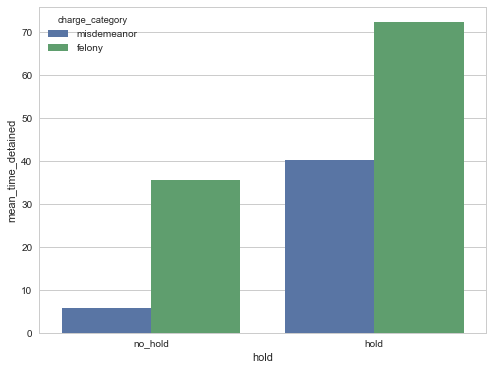

In [305]:
ax = sns.barplot(x='hold', y='mean_time_detained', hue='charge_category', hue_order=['misdemeanor', 'felony'], data=table)

In [306]:
ttest = scipystats.ttest_ind(df[hold]['time_detained'], df[~hold]['time_detained'])

In [307]:
ttest

Ttest_indResult(statistic=5.54147464045605, pvalue=3.0422420381957485e-08)

In [308]:
ttest.pvalue

3.0422420381957485e-08

# Regressions

In [311]:
# Using topcounted charge values
formula = "log_time_detained ~ imm_hold + charge_topcount + male + black + hispanic + amer_indian_alaskan + asian_pacific_island + max_seriousness + felony + drug + sex + property + violent + other"
reg = smf.ols(formula = formula, data = df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_time_detained   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     580.7
Date:                Tue, 24 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:03:50   Log-Likelihood:                -35153.
No. Observations:               17652   AIC:                         7.034e+04
Df Residuals:                   17637   BIC:                         7.045e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9698      0.086    -22.883      0.000      -2.139      -1.801
imm_hold                 1.2331      0.171      7.227      0.000       0.899       1.568
charge_topcount          0.5987      0.009     69.597      0.000       0.582       0.616
male                     0.1454      0.032      4.574      0.000       0.083       0.208
black                    0.0980      0.033      3.008      0.003       0.034       0.162
hispanic                -0.0693      0.051     -1.369      0.171      -0.168       0.030
amer_indian_alaskan      0.3014      0.079      3.839      0.000       0.148       0.455
asian_pacific_island    -0.1005      0.058     -1.726      0.084      -0.215       0.014
max_seriousness          0.5469      0.029     19.157      0.000       0.491       0.603
felony                  -0.1522      0.064     -2.387      0.017      -0.277      -0.027
drug                     0.3052      0.057      5.389      0.000       0.194       0.416
sex                      0.3142      0.114      2.768      0.006       0.092       0.537
property                -0.1747      0.041     -4.221      0.000      -0.256      -0.094
violent                  0.2461      0.045      5.468      0.000       0.158       0.334
other                    1.8376      0.092     19.930      0.000       1.657       2.018
==============================================================================
Omnibus:                      390.759   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              477.991
Skew:                          -0.302   Prob(JB):                    1.60e-104
Kurtosis:                       3.534   Cond. No.                         58.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [312]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
time_detained,17652.0,25.359933,62.996963,0.004861,0.965972,2.836111,20.833507,1314.554167
amer_indian_alaskan,17652.0,0.030478,0.171904,0.000000,0.000000,0.000000,0.000000,1.000000
asian_pacific_island,17652.0,0.057840,0.233448,0.000000,0.000000,0.000000,0.000000,1.000000
black,17652.0,0.239973,0.427079,0.000000,0.000000,0.000000,0.000000,1.000000
hispanic,17652.0,0.084070,0.277500,0.000000,0.000000,0.000000,0.000000,1.000000
white,17652.0,0.587639,0.492273,0.000000,0.000000,1.000000,1.000000,1.000000
female,17652.0,0.238330,0.426074,0.000000,0.000000,0.000000,0.000000,1.000000
male,17652.0,0.761670,0.426074,0.000000,1.000000,1.000000,1.000000,1.000000
max_seriousness,17652.0,3.521187,1.579590,0.000000,3.000000,4.000000,5.000000,6.000000
felony,17652.0,0.612169,0.487270,0.000000,0.000000,1.000000,1.000000,1.000000


In [313]:
reg.params

Intercept              -1.969797
imm_hold                1.233119
charge_topcount         0.598679
male                    0.145352
black                   0.098015
hispanic               -0.069252
amer_indian_alaskan     0.301424
asian_pacific_island   -0.100487
max_seriousness         0.546947
felony                 -0.152202
drug                    0.305220
sex                     0.314248
property               -0.174673
violent                 0.246134
other                   1.837633
dtype: float64

In [314]:
# Does this work as a predictive equation? Reference categories: race = white, crime type = public order
log_time_detained = (reg.params['Intercept'] + 
                    (reg.params['imm_hold'] * 1) + 
                    (reg.params['charge_topcount'] * 1.7) +
                    (reg.params['male'] * 1) +
                    (reg.params['black'] * 0) +
                    (reg.params['hispanic'] * 1) +
                    (reg.params['amer_indian_alaskan'] * 0) +
                    (reg.params['asian_pacific_island'] * 0) +
                    (reg.params['max_seriousness'] * 3.52) +
                    (reg.params['felony'] * 1) +
                    (reg.params['drug'] * 0) +
                    (reg.params['sex'] * 0) +
                    (reg.params['property'] * 0) +
                    (reg.params['violent'] * 0) +
                    (reg.params['other'] * 0))
predicted_time_detained_0 = np.power(np.e, log_time_detained)
print(f'{predicted_time_detained_0}')

8.416776921721542


In [316]:
# Does this work as a predictive equation? Reference categories: race = white, crime type = public order
log_time_detained = (reg.params['Intercept'] + 
                    (reg.params['imm_hold'] * 0) + 
                    (reg.params['charge_topcount'] * 1.7) +
                    (reg.params['male'] * 1) +
                    (reg.params['black'] * 0) +
                    (reg.params['hispanic'] * 1) +
                    (reg.params['amer_indian_alaskan'] * 0) +
                    (reg.params['asian_pacific_island'] * 0) +
                    (reg.params['max_seriousness'] * 3.52) +
                    (reg.params['felony'] * 1) +
                    (reg.params['drug'] * 0) +
                    (reg.params['sex'] * 0) +
                    (reg.params['property'] * 0) +
                    (reg.params['violent'] * 0) +
                    (reg.params['other'] * 0))
predicted_time_detained_1 = np.power(np.e, log_time_detained)
print(f'{predicted_time_detained_1}')

2.452499152145784


In [317]:
predicted_time_detained_0 / predicted_time_detained_1

3.4319183818503616

In [318]:
(predicted_time_detained_0 - predicted_time_detained_1)

5.9642777695757587

In [319]:
(np.power(np.e, reg.params) - 1) * 100

Intercept               -86.051483
imm_hold                243.191838
charge_topcount          81.971258
male                     15.644686
black                    10.297967
hispanic                 -6.690836
amer_indian_alaskan      35.178208
asian_pacific_island     -9.560308
max_seriousness          72.796909
felony                  -14.118525
drug                     35.692288
sex                      36.922858
property                -16.026879
violent                  27.907103
other                   528.165030
dtype: float64

# Alternate way of setting up regression. Same results!

In [ ]:
from patsy import dmatrices

In [ ]:
formula = "log_time_detained ~ imm_hold + charge_topcount + male + black + hispanic + amer_indian_alaskan + asian_pacific_island + max_seriousness + felony + drug + sex + property + violent + other"
y, X = dmatrices(formula, data=df, return_type='dataframe')

In [ ]:
y.head()

In [ ]:
X.head()

In [ ]:
mod = sm.OLS(y, X)    # Describe model

In [ ]:
res = mod.fit()       # Fit model

In [ ]:
res.summary()

# Correlation matrices

Not sure if this is useful, but we do see correlations between `log_time_detained` and `imm_hold`; and `imm_hold` and `hispanic`.

In [ ]:
from string import ascii_letters
import matplotlib.pyplot as plt

In [ ]:
corr = df.corr()

In [ ]:
corr

In [ ]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Hand coded bookings with holds

In [ ]:
handcoded = pd.read_csv('../frozen/handcoded_bookings_with_hold.csv')

In [ ]:
handcoded.columns = handcoded.columns.str.strip()

In [ ]:
handcoded['Date of Release'] = pd.to_datetime(handcoded['Date of Release'])

In [ ]:
len(handcoded)

In [ ]:
handcoded['Country of Origin'].value_counts()

In [ ]:
release_to = handcoded['Released to who?'].fillna('IMM')

In [ ]:
released = release_to != 'Not Released'

In [ ]:
release_to[released].value_counts() / len(release_to[released]) * 100

In [ ]:
len(release_to[released])

In [ ]:
handcoded_ids = set(handcoded['Booking ID'])

In [ ]:
len(handcoded_ids)

In [ ]:
all_ids = set(bookings_by_date['booking_id'])

In [ ]:
len(handcoded_ids.intersection(all_ids))

In [ ]:
diff_ids = handcoded_ids.difference(hold_ids)

In [ ]:
len(diff_ids)

In [ ]:
handcoded[handcoded['Booking ID'].isin(diff_ids)]['Date of Release']

In [ ]:
bookings_by_date[bookings_by_date['booking_id'].isin(diff_ids)]

In [ ]:
release_disp[release_disp['booking_id'].isin(handcoded_ids)].drop_duplicates(subset='booking_id')

# Hispanic surname analysis

Trying out one method to analyze ethnicity. Doesn't seem too accurate? The `ethnicolr` module has some other methods that use full name, might work better.

In [ ]:
from ethnicolr import census_ln, pred_census_ln, pred_wiki_name

In [ ]:
hsa = bookings_by_date.copy()

In [ ]:
hsa['last'], hsa['first'] = hsa['inmate_name'].str.split(',', 1).str

In [ ]:
hsa = pred_census_ln(hsa, 'last', 2010)

In [ ]:
hsa['race_desc'].value_counts()

In [ ]:
hsa['race'].value_counts()

## Experimenting with dummy variables

In [ ]:
release_disp_dummies = pd.get_dummies(merge['release_disposition_desc'])
booking_charge_dummies = pd.get_dummies(merge['booking_charge_desc'])

In [ ]:
release_disp_dummies.columns = release_disp_dummies.columns.str.replace(' ', '_')
release_disp_dummies.columns = release_disp_dummies.columns.str.replace('/', '_')
release_disp_dummies.columns = release_disp_dummies.columns.str.lower()

In [ ]:
booking_charge_dummies.columns = booking_charge_dummies.columns.str.replace(' ', '_')
booking_charge_dummies.columns = booking_charge_dummies.columns.str.replace('/', '_')
booking_charge_dummies.columns = booking_charge_dummies.columns.str.lower()

In [ ]:
booking_ids = merge['booking_id']

In [ ]:
release_disp_dummies = pd.concat([booking_ids, release_disp_dummies], axis=1)
booking_charge_dummies = pd.concat([booking_ids, booking_charge_dummies], axis=1)

We can sum up dummies for each `booking id`, returning quantitative rather than categorical variables. Do we care about quantities here, since we're already calculating # of charges? We can change values > 1 to = 1, but is that reliable?

In [ ]:
release_disp_sums = release_disp_dummies.groupby('booking_id').sum()

In [ ]:
release_disp_sums[release_disp_sums.loc[:,:] > 1] = 1

In [ ]:
release_disp_cat = release_disp_sums.reset_index()

In [ ]:
booking_charge_sums = booking_charge_dummies.groupby('booking_id').sum()

In [ ]:
booking_charge_sums[booking_charge_sums.loc[:,:] > 1] = 1

In [ ]:
booking_charge_cat = booking_charge_sums.reset_index()

Resulting merge is huge, maybe will be more useful once we categorize charges, release disps

In [ ]:
big_merge = pd.merge(merge, release_disp_cat, on='booking_id', how='left')

In [ ]:
big_merge = pd.merge(big_merge, booking_charge_cat, on='booking_id', how='left')